# Entrega Case foursys

Este notebook está dividido em 3 partes cada uma representando a entrega correspondente.

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from scipy.stats import uniform, randint

In [72]:
churn_data    = pd.read_csv('/content/drive/MyDrive/Testetecnico/churn_data.csv')
customer_data = pd.read_csv('/content/drive/MyDrive/Testetecnico/customer_data.csv')
internet_data = pd.read_csv('/content/drive/MyDrive/Testetecnico/internet_data.csv')
dictionary    = pd.read_csv('/content/drive/MyDrive/Testetecnico/Telecom_Churn_Data_Dictionary.csv',encoding='windows-1254')

In [73]:
# União dos dados em 1 dataframe e correção de dados faltantes
telecom_churn_data = customer_data.merge(internet_data).merge(churn_data)

telecom_churn_data['TotalCharges'] = telecom_churn_data.TotalCharges.apply(lambda x: 0  if x == ' ' else float(x))

# Entrega 1

Um bom ponto de partida é entender qual o Churn atual:

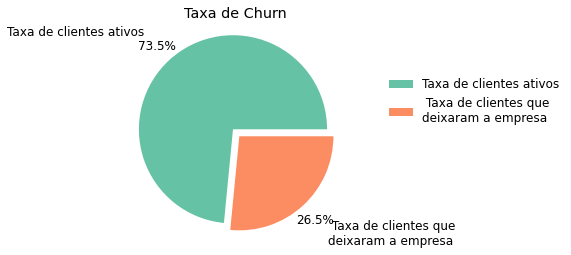

In [74]:
total     = telecom_churn_data['Churn'].count()
churn_yes = telecom_churn_data[telecom_churn_data['Churn'] == 'Yes']['Churn'].count() / total
churn_no  = telecom_churn_data[telecom_churn_data['Churn'] == 'No']['Churn'].count()  / total

fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size']=12

labels = ['Taxa de clientes ativos',' Taxa de clientes que\ndeixaram a empresa']
percentages = [churn_no, churn_yes]
explode=(0.1,0)

#['#CCFFFF','#FF8000']

color_palette_list = [sns.color_palette('Set2')[0],sns.color_palette('Set2')[1] ]
ax.pie(percentages, explode=explode, labels=labels,  
        colors = color_palette_list,autopct='%0.1f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Taxa de Churn")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

Para ter uma ideia de quais variáveis devo explorar começo visualizando a correlação entre as variáveis e o valor de churn. Como existem muitas variáveis categóricas primeiro realizo um pré-processamento dos dados. Um ponto a ser lembrado é de que correlação não implica causalidade, portanto é só uma forma de nortear a busca por informações relevantes.

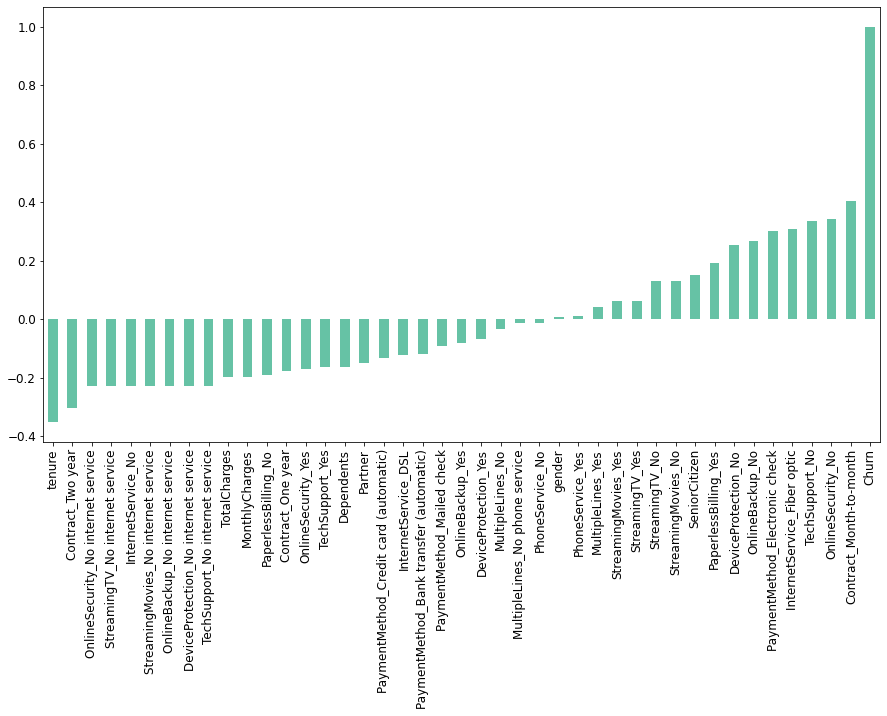

In [92]:
df = telecom_churn_data.iloc[:,1:]
df["Churn"].replace(to_replace="Yes", value=1, inplace=True)
df["Churn"].replace(to_replace="No",  value=0, inplace=True)

'''
Em testes prévios sem essa codificação os valores para 'Yes' ou 'No' possuiam módulos iguais
Para diminuir o numero de features a serem consideradas decidi fazer essa alteração
'''
df["Partner"].replace(to_replace="Yes", value=1, inplace=True)
df["Partner"].replace(to_replace="No",  value=0, inplace=True)
df["Dependents"].replace(to_replace="Yes", value=1, inplace=True)
df["Dependents"].replace(to_replace="No",  value=0, inplace=True)
df["gender"].replace(to_replace="Female", value=1, inplace=True)
df["gender"].replace(to_replace="Male",  value=0, inplace=True)


dummie_telecom_churn_data = pd.get_dummies(df)
#dummie_telecom_churn_data.head(5)
plt.figure(figsize=(15,8))
dummie_telecom_churn_data.corr()['Churn'].sort_values().plot(kind='bar',color=sns.color_palette("Set2")[0])

Nesse ponto decidi escolher as 5 variáveis com menor e com maior correlação.

Ou seja: 
* tenure;
* Contract_Two year;
* InternetService_No;
* TotalCharges;
* PaperlessBilling_No; 

(5 com menor correlação)

* PaymentMethod_Eletronic check;
* InternetService_Fiber optic;
* TechSupport_No;
* OnlineSecurity_No;
* e Contract_Month-to-month.

(5 com maior correlações)



Observando o gráfico ainda podemos ver que dentre as 10 primeiras variáveis 7 se referem ao caso onde o cliente não contratou internet e por isso decidi escolher as váriaveis seguintes (TotalCharges e PaperlessBilling_No).

Outra informação que podemos extrair é a de que os dados do clientes (Partners, SeniorCitizen, Dependents, gender) se mostraram pouco relevantes na correlação. 

Vamos explorar a variável tenure e sua relação com a saída de um cliente do plano. Entender em que instante de tempo um cliente deixa a empresa pode ser valioso para traçar estratégias, seja em contratos ou promoções que ajudem a fidelizar o cliente.

Por se tratar de uma comparação entre uma variável numérica e uma categórica o gráfico escolhido foi o que segue: 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


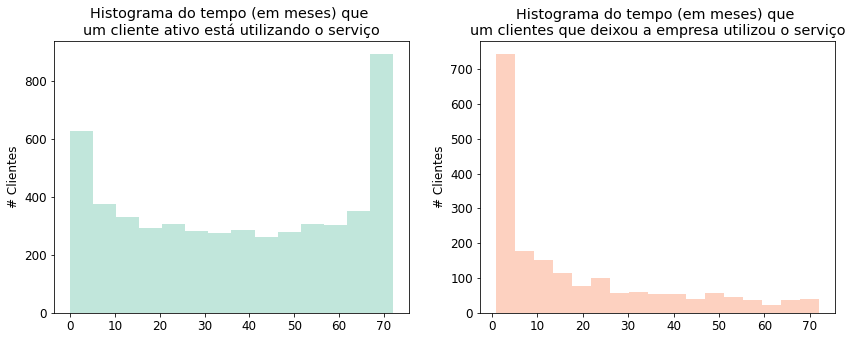

<Figure size 432x288 with 0 Axes>

In [76]:
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
sns.distplot(telecom_churn_data.loc[telecom_churn_data.Churn=='No','tenure'],hist=True,color=sns.color_palette('Set2')[0],kde=False)
_ = plt.title('Histograma do tempo (em meses) que \num cliente ativo está utilizando o serviço')
_ = plt.xlabel('')
_ = plt.ylabel('# Clientes')
_ = plt.subplot(1,2,2)
sns.distplot(telecom_churn_data.loc[telecom_churn_data.Churn=='Yes','tenure'],hist=True, color=sns.color_palette('Set2')[1],kde=False)
_ = plt.title('Histograma do tempo (em meses) que \num clientes que deixou a empresa utilizou o serviço')
_ = plt.xlabel('')
_ = plt.ylabel('# Clientes')
#print("Mean Tenure of Two groups\n",round(telecom_churn_data.groupby('Churn').tenure.mean(),1))
_ = plt.figure()

Vejamos agora como o tipo de contrato pode influenciar na permanência de um cliente.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


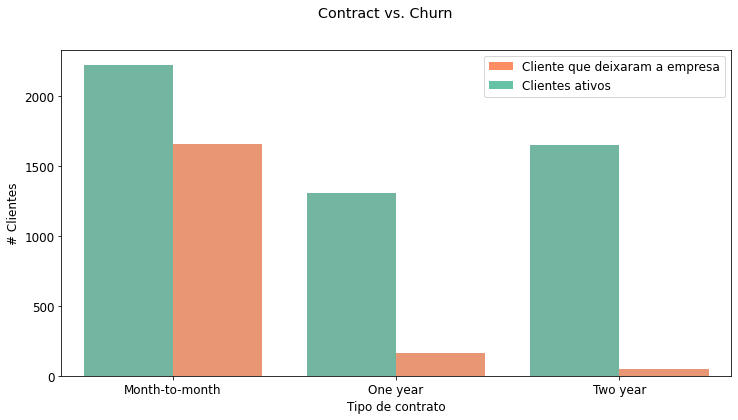

In [77]:
fig, ax = plt.subplots(figsize=(12,6))

palette = 'Set2'

sns.countplot('Contract', hue='Churn', data=telecom_churn_data, palette=palette, ax=ax)

ax.set_xlabel('Tipo de contrato')
ax.set_ylabel('# Clientes')

color_patches = [
    Patch(facecolor=sns.color_palette('Set2')[1], label='Cliente que deixaram a empresa'),
    Patch(facecolor=sns.color_palette('Set2')[0], label='Clientes ativos')
]
ax.legend(handles=color_patches)

fig.suptitle('Contract vs. Churn');

Pelo gráfico é possível ver que clientes que possuem contrato Month-to-month acabam deixando mais a empresa em contrapartida clientes com contrato Two year são os que menos deixam a empresa.

Como o maior número de cliente que deixa a empresa se encontra em contratos Month-to-month vamos analisar agora o tipo do plano de internet para clientes com esse contrato.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


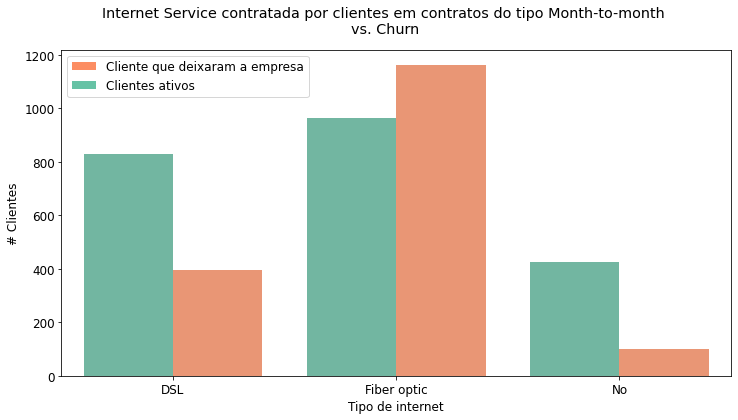

In [78]:
fig, ax = plt.subplots(figsize=(12,6))

sns.countplot("InternetService", hue="Churn", data=telecom_churn_data[telecom_churn_data['Contract']=='Month-to-month'], palette=palette, ax=ax)

ax.set_xlabel("Tipo de internet")
ax.set_ylabel('# Clientes')

ax.legend(handles=color_patches)

fig.suptitle("Internet Service contratada por clientes em contratos do tipo Month-to-month \nvs. Churn");

Podemos notar que clientes que contratam internet tipo Fiber optic em contratos tipo Month-to-month tem uma maior tendência a deixar a empresa, superando o número de clientes ativos.

Veja, anteriormente eu havia escolhido a variável "Total Charges" por conta da correlação, mas essa variável acaba dependendo do valor mensal e do tempo que um cliente permanece, nós já vimos quanto tempo o cliente se mantém então nesse momento é melhor observar como o gasto mensal impacta na saída de um cliente

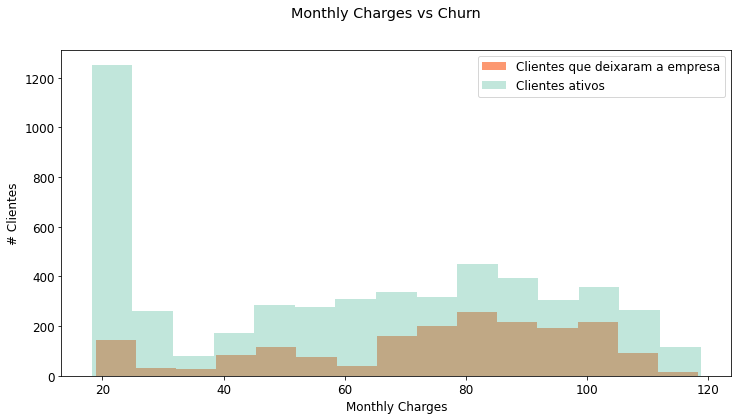

In [79]:
fig, ax = plt.subplots(figsize=(12,6))
telecom_churn_data['MonthlyCharges'] = telecom_churn_data.TotalCharges.apply(lambda x: 0  if x == ' ' else int(round(x,0)))

ax.hist(df[df["Churn"]==1]["MonthlyCharges"], bins=15, alpha=0.9, color=sns.color_palette('Set2')[1], label="Clientes que deixaram a empresa")
ax.hist(df[df["Churn"]==0]["MonthlyCharges"], bins=15, alpha=0.4, color=sns.color_palette('Set2')[0], label="Clientes ativos")

ax.set_xlabel("Monthly Charges")
ax.set_ylabel("# Clientes")

fig.suptitle("Monthly Charges vs Churn")

ax.legend();

É nítido que clientes cuja o monthly charge é pequeno(faixa de 20-60) tendem a se manter como clientes enquanto a medidade que essa variável aumenta temos um número maior de clientes que optam por deixar a empresa.

A próxima variável escolhida é a TechSupport, pensando sobre o negócio quando temos alguma dificuldade é a esse serviço que recorremos e portanto tem impacto direto na satisfação e decisão de um cliente ao deixar a empresa.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


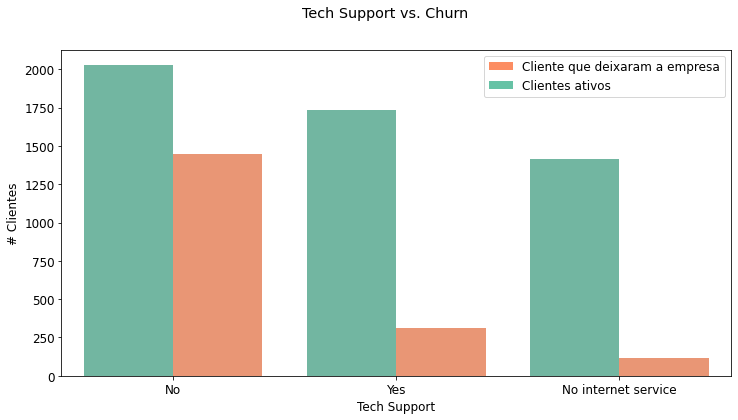

In [80]:
fig, ax = plt.subplots(figsize=(12,6))

sns.countplot("TechSupport", hue="Churn", data=telecom_churn_data, palette=palette, ax=ax)

ax.set_xlabel("Tech Support")
ax.set_ylabel("# Clientes")

ax.legend(handles=color_patches)

fig.suptitle("Tech Support vs. Churn");

Podemos notar como havia dito que aqueles clientes que não contratam o suporte técnico são a maioria e também o que apresentam maior taxa de abandono da empresa.

Olhando para os dados do tipo de pagamento que um cliente opta por fazer a primeira impressão não é possível dizer nada além do que a correlação já mostrava contudo se olharmos para os clientes que optaram por faturamento sem papel e pagamento por Electronic check vemos que a proporção fica praticamente igual. Causas diversas podem causar isso, clientes desatentos que esquecem de pagar a conta e deixam a empresa por inadimplencia  (tem seus planos cancelados) podem ter sido considerados nesseses dados. A necessidade de uma nova coleta de dados fica clara nesse ponto.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


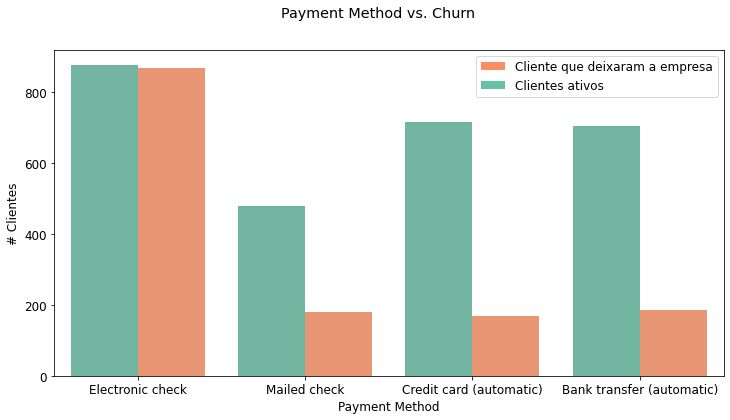

In [81]:
fig, ax = plt.subplots(figsize=(12,6))

sns.countplot("PaymentMethod", hue="Churn", data=telecom_churn_data[telecom_churn_data['PaperlessBilling']=='Yes'], palette=palette, ax=ax)

ax.set_xlabel("Payment Method")
ax.set_ylabel("# Clientes")

ax.legend(handles=color_patches)

fig.suptitle("Payment Method vs. Churn");

As demais variáveis citadas após a correlação foram analisadas contudo não revelaram dados significativos e portanto não entraram na versão final deste documento.

# Entrega 2


Com toda a exploração inicial já é possível ter uma ideia das 5 variáveis que melhor explicam a situação de um cliente que está abandonando a empresa. Sabemos até agora que clientes com contrato Month-to-month, que contratam Fiberoptic, que estão em nos primeiros 18 meses e/ou que possuem contas mensais maiores que  60 são os que mais deixam a empresa.

Contudo mais uma técnica será aplicada. Utilizando um modelo de Aprendizado de Máquina tentaremos fazer a predição se um cliente vai sair ou não e com o modelo treinado podemos verificar quais variáveis ele considera mais importante.

In [82]:
X = dummie_telecom_churn_data.drop(["Churn"], axis=1)
Y = dummie_telecom_churn_data.Churn

# divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.2)

randomforest_model = RandomForestClassifier(bootstrap='True', criterion='gini', n_estimators=171 ,random_state=42).fit(X_train,y_train)
predict = randomforest_model.predict(X_test)
accuracy_score(y_test,predict)

0.794180269694819

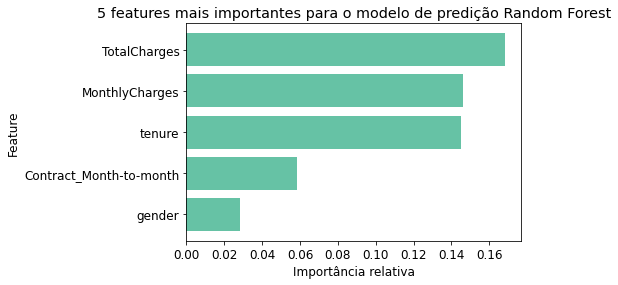

In [89]:
features = randomforest_model.feature_importances_
n = 5
i = np.argsort(features)[-n:]
cols = X_train.columns
plt.barh(cols[i], features[i],color=sns.color_palette('Set2')[0])
#plt.grid()
plt.title(f"{n} features mais importantes para o modelo de predição Random Forest")
plt.xlabel("Importância relativa")
plt.ylabel("Feature")
plt.show()

A primeira variável é a TotalCharges contudo é uma variável dependente de tenure e MonthlyCharges e como não ouve um pré-processamento de seus valores os valores variam bastante, portanto mais uma vez optei pelas variáveis independentes.

Unindo a exploração inicial com as features mais importantes do modelo e o problema é possível dizer que as 5 variáveis que melhor explicam a situação de um cliente que está abandonando a empresa são:

* Tenure
* Monthly Charges
* Contract 
* Tech Support
* Paymente Method

Veja podemos nos perguntar também o que nos faria deixar a empresa atual? 

Coisa como "É muito caro" e "Não tenho suporte para os meus problemas" podem ser algumas respostas que vão surgir, por outro lado se ja utilizo o serviço de uma empresa a anos tenho um bom suporte e não pago caro provavelmente me manterei nesse contrato pois seria mais cômodo do que buscar uma nova empresa.

# Entrega 3


Observando os dados e as variáveis selecionadas uma pergunta que faria é se  caso o serviço de suporte fosse incluso ao contratar um plano de internet o churn diminuiria? Afinal um bom atendimento pode influenciar na fidelização de um cliente.


Para isso vou utilizar a base de dados sem os clientes que não contrataram o TechSupport e então recalcular o valor do churn para então comparar com o valor inicial


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


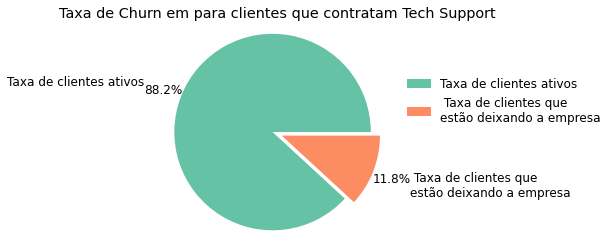

In [91]:
data_withTechSupport = telecom_churn_data[telecom_churn_data['TechSupport'] != 'No']

total     = data_withTechSupport['Churn'].count()
churn_yes = data_withTechSupport[telecom_churn_data['Churn'] == 'Yes']['Churn'].count() / total
churn_no  = data_withTechSupport[telecom_churn_data['Churn'] == 'No']['Churn'].count()  / total

fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size']=12

labels = ['Taxa de clientes ativos',' Taxa de clientes que\nestão deixando a empresa']
percentages = [churn_no, churn_yes]
explode=(0.1,0)

#['#CCFFFF','#FF8000']

color_palette_list = [sns.color_palette('Set2')[0],sns.color_palette('Set2')[1] ]
ax.pie(percentages, explode=explode, labels=labels,  
        colors = color_palette_list,autopct='%0.1f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Taxa de Churn em para clientes que contratam Tech Support")
ax.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

Veja se os clientes que contratassem InternetService tivessem também contratado o TechSupport o churn seria de 11.8% representando uma variação de até 44,5% em relação ao churn atual.